In [13]:
!pip install tensorflow keras numpy matplotlib opencv-python pillow flask-ngrok

In [1]:
import numpy as np
import os
import requests
import zipfile
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
CATEGORIES = ['cat', 'dog', 'house', 'tree', 'car', 'apple', 'banana', 'clock']

def download_quickdraw_data():

    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
    data_dir = 'quickdraw_data'

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    X = []
    y = []

    for i, category in enumerate(CATEGORIES):
        filename = f"{category.replace(' ', '%20')}.npy"
        filepath = os.path.join(data_dir, filename)

        if not os.path.exists(filepath):
            print(f"Downloading {category} data...")
            try:
                response = requests.get(base_url + filename, stream=True)
                with open(filepath, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=1024):
                        if chunk:
                            f.write(chunk)
            except Exception as e:
                print(f"Failed to download {category}: {e}")
                continue

        try:
            category_data = np.load(filepath)
            num_samples = min(10000, len(category_data))
            category_data = category_data[:num_samples]

            category_data = category_data.reshape(-1, 28, 28, 1).astype('float32') / 255.0

            X.append(category_data)
            y.append(np.full(len(category_data), i))

            print(f"Loaded {len(category_data)} samples for {category}")

        except Exception as e:
            print(f"Error loading {category}: {e}")
            continue

    if not X:
        raise ValueError("No data was loaded. Check your internet connection or category names.")

    X = np.vstack(X)
    y = np.hstack(y)

    y = to_categorical(y, num_classes=len(CATEGORIES))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, CATEGORIES

In [3]:
print("Downloading and preprocessing QuickDraw dataset...")
X_train, X_val, X_test, y_train, y_val, y_test, CATEGORIES = download_quickdraw_data()

np.savez('quickdraw_data/preprocessed_data.npz',
         X_train=X_train, X_val=X_val, X_test=X_test,
         y_train=y_train, y_val=y_val, y_test=y_test,
         categories=CATEGORIES)

print("Data preparation complete!")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Categories: {CATEGORIES}")

Loaded 10000 samples for cat
Loaded 10000 samples for dog
Loaded 10000 samples for house
Loaded 10000 samples for tree
Loaded 10000 samples for car
Loaded 10000 samples for apple
Loaded 10000 samples for banana
Loaded 10000 samples for clock
Data preparation complete!
Training data shape: (57600, 28, 28, 1)
Validation data shape: (6400, 28, 28, 1)
Test data shape: (16000, 28, 28, 1)
Categories: ['cat', 'dog', 'house', 'tree', 'car', 'apple', 'banana', 'clock']


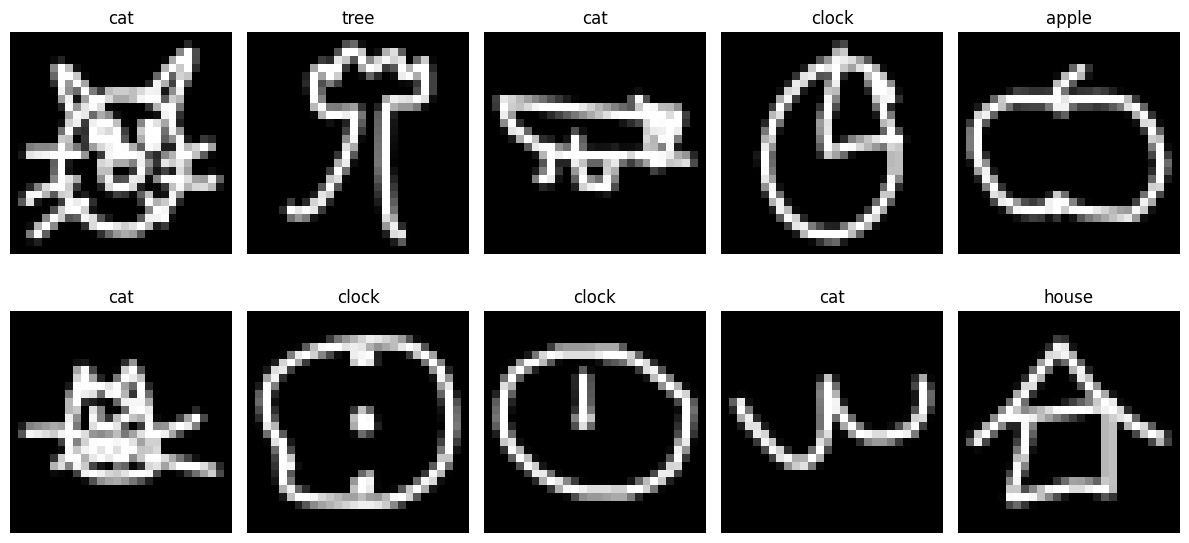

In [4]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(CATEGORIES[np.argmax(y_train[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def create_improved_model(input_shape, num_classes):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [6]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=False
)

input_shape = (28, 28, 1)
model = create_improved_model(input_shape, len(CATEGORIES))
model.summary()

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_accuracy'),
    ModelCheckpoint('best_doodle_model.h5', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
]

batch_size = 128
epochs = 50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 539,240 (2.06 MB)

 Trainable params: 537,064 (2.05 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [7]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5648 - loss: 2.2595

450/450 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.5654 - loss: 2.2571 - val_accuracy: 0.5772 - val_loss: 2.0126 - learning_rate: 0.0010
Epoch 2/50
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8539 - loss: 1.0573

450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8539 - loss: 1.0569 - val_accuracy: 0.9186 - val_loss: 0.6737 - learning_rate: 0.0010
Epoch 3/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8862 - loss: 0.7219

450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8862 - loss: 0.7217 - val_accuracy: 0.9241 - val_loss: 0.4840 - learning_rate: 0.0010
Epoch 4/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9024 - loss: 0.5174

450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9024 - loss: 0.5173 - val_accuracy: 0.9322 - val_loss: 0.3565 - learning_rate: 0.0010
Epoch 5/50
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9055 - loss: 0.4230

450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9055 - loss: 0.4230 - val_accuracy: 0.9359 - val_loss: 0.3067 - learning_rate: 0.0010
Epoch 6/50
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9108 - loss: 0.3685

450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9108 - loss: 0.3685 - val_accuracy: 0.9364 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 7/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9140 - loss: 0.3462 - val_accuracy: 0.9327 - val_loss: 0.2845 - learning_rate: 0.0010
Epoch 8/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9154 - loss: 0.3387 - val_accuracy: 0.9333 - val_loss: 0.2742 - learning_rate: 0.0010
Epoch 9/50
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9194 - loss: 0.3178

450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9194 - loss: 0.3178 - val_accuracy: 0.9430 - val_loss: 0.2546 - learning_rate: 0.0010
Epoch 10/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9229 - loss: 0.3125 - val_accuracy: 0.9380 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 11/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9238 - loss: 0.3072

450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9238 - loss: 0.3072 - val_accuracy: 0.9433 - val_loss: 0.2514 - learning_rate: 0.0010
Epoch 12/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9242 - loss: 0.3041 - val_accuracy: 0.9380 - val_loss: 0.2604 - learning_rate: 0.0010
Epoch 13/50
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9284 - loss: 0.2949

450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9283 - loss: 0.2949 - val_accuracy: 0.9456 - val_loss: 0.2457 - learning_rate: 0.0010
Epoch 14/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9317 - loss: 0.2881 - val_accuracy: 0.9436 - val_loss: 0.2573 - learning_rate: 0.0010
Epoch 15/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9296 - loss: 0.2919 - val_accuracy: 0.9433 - val_loss: 0.2476 - learning_rate: 0.0010
Epoch 16/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9310 - loss: 0.2839

450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9310 - loss: 0.2839 - val_accuracy: 0.9475 - val_loss: 0.2386 - learning_rate: 0.0010
Epoch 17/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9288 - loss: 0.2873 - val_accuracy: 0.9450 - val_loss: 0.2478 - learning_rate: 0.0010
Epoch 18/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9325 - loss: 0.2804 - val_accuracy: 0.9428 - val_loss: 0.2535 - learning_rate: 0.0010
Epoch 19/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9331 - loss: 0.2760 - val_accuracy: 0.9441 - val_loss: 0.2414 - learning_rate: 0.0010
Epoch 20/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9361 - loss: 0.2682 - val_accuracy: 0.9422 - val_loss: 0.2390 - learning_rate: 0.0010
Epoch 21/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9360 - loss: 0.2670 - val_accuracy: 0.9413 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 22/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9401 - loss: 0

450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.9401 - loss: 0.2468 - val_accuracy: 0.9513 - val_loss: 0.2022 - learning_rate: 2.0000e-04
Epoch 23/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9438 - loss: 0.2151

450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9438 - loss: 0.2151 - val_accuracy: 0.9519 - val_loss: 0.1871 - learning_rate: 2.0000e-04
Epoch 24/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9439 - loss: 0.2024 - val_accuracy: 0.9500 - val_loss: 0.1773 - learning_rate: 2.0000e-04
Epoch 25/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.9467 - loss: 0.1915 - val_accuracy: 0.9513 - val_loss: 0.1754 - learning_rate: 2.0000e-04
Epoch 26/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9451 - loss: 0.1888 - val_accuracy: 0.9509 - val_loss: 0.1681 - learning_rate: 2.0000e-04
Epoch 27/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.9451 - loss: 0.1882 - val_accuracy: 0.9497 - val_loss: 0.1725 - learning_rate: 2.0000e-04
Epoch 28/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9453 - loss: 0.1880 - val_accuracy: 0.9513 - val_loss: 0.1703 - learning_rate: 2.0000e-04
Epoch 29/50
450/450 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - a

In [8]:
model = tf.keras.models.load_model('best_doodle_model.h5')

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9517


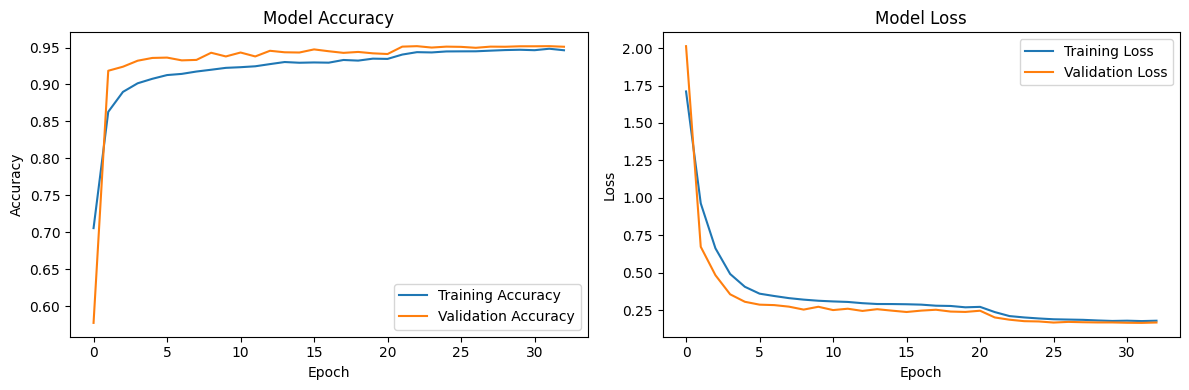

In [10]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


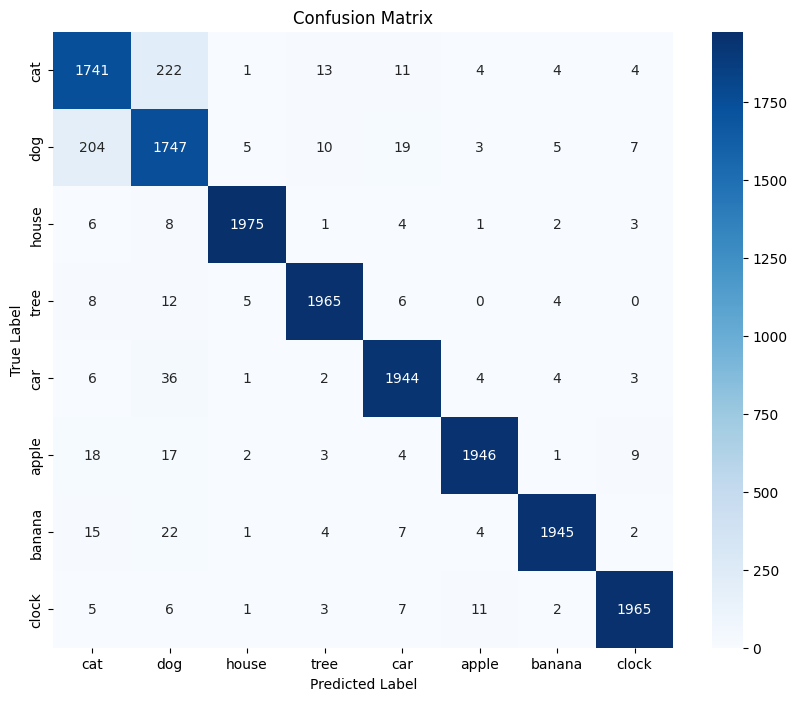

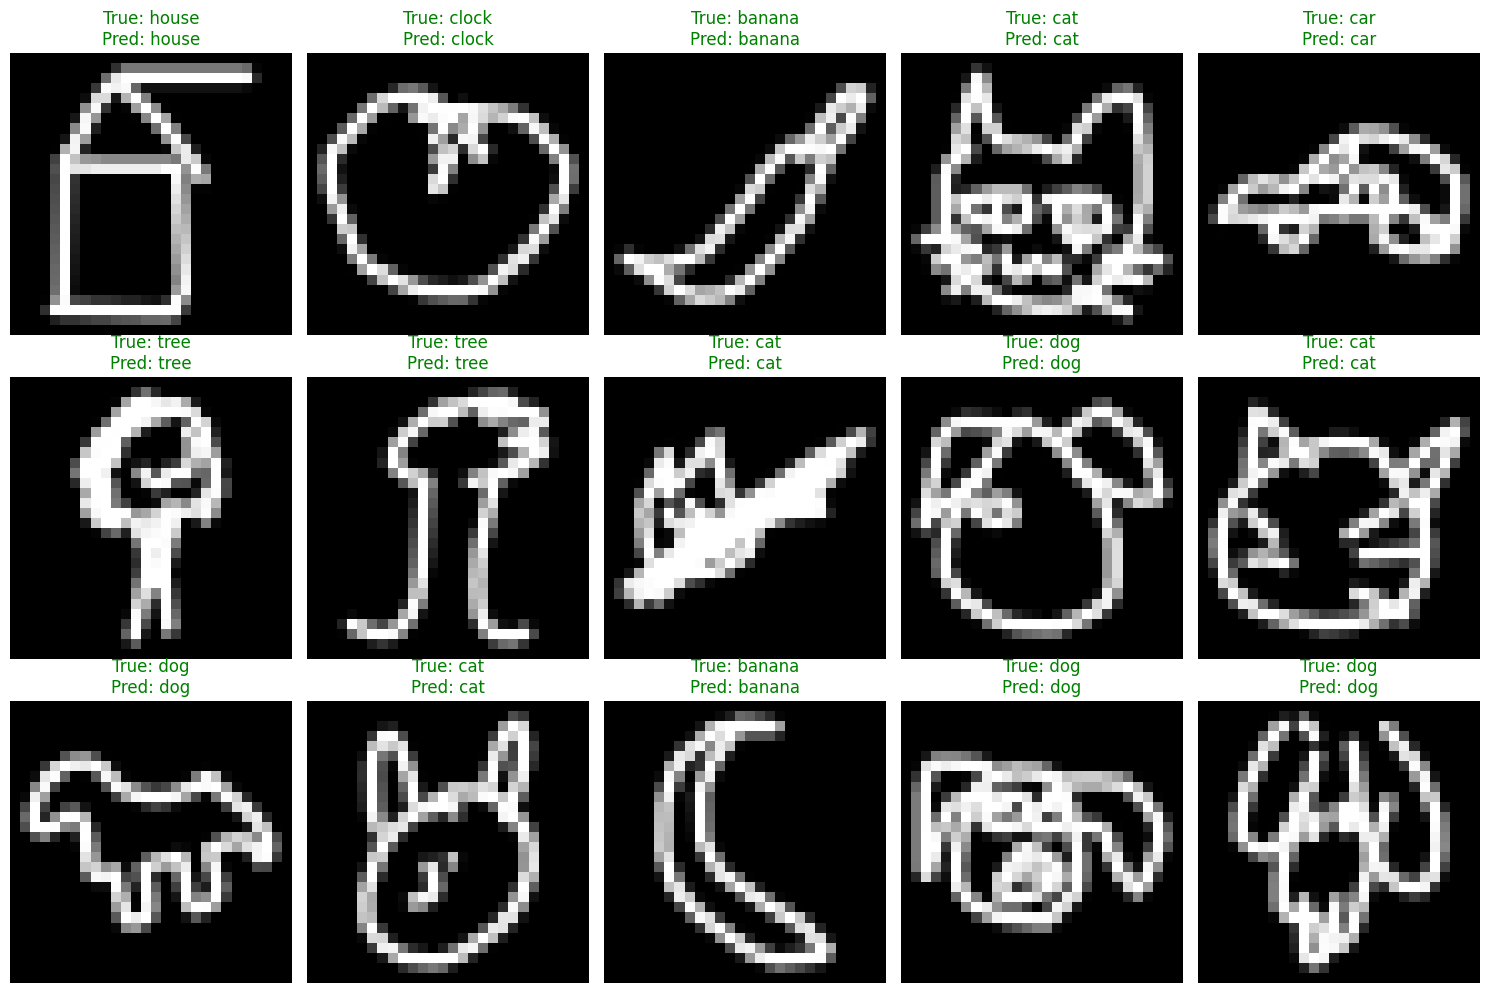

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')

    pred_label = CATEGORIES[y_pred_classes[i]]
    true_label = CATEGORIES[y_true[i]]

    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
from google.colab import files

files.download('best_doodle_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>